In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
cd/content/drive/MyDrive/Dental dataset

/content/drive/MyDrive/Dental dataset


In [65]:
import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Input,MaxPooling2D,UpSampling2D
from tensorflow.keras.optimizers import Adam

In [66]:
root_dir="valid/"

In [67]:
img_paths=os.listdir(root_dir)
len(img_paths)

122

# Read Dataset


In [68]:

images=[]
for img_path in img_paths:
  path = pathlib.Path(root_dir + img_path)
  if path.is_file():
    img=load_img(root_dir + img_path,target_size=(64,64),color_mode="grayscale")
    img=img_to_array(img)
    img=img/255
    images.append(img)
  else:
    print("Skipping {} because it is a directory".format(img_path))

Skipping .ipynb_checkpoints because it is a directory


In [69]:
images=np.array(images)

In [70]:
type(images)

numpy.ndarray

# Display Dataset

In [71]:
def visualize_df(df: np.ndarray):
  fig,axes=plt.subplots(4,4,figsize=(12,12))
  for i ,ax in enumerate(axes.ravel()):
    if i< len(df):
      img=df[i]
      ax.imshow(img, cmap="gray")
      ax.axis("off")
    else:
      ax.axis("off")
  plt.tight_layout()
  plt.show


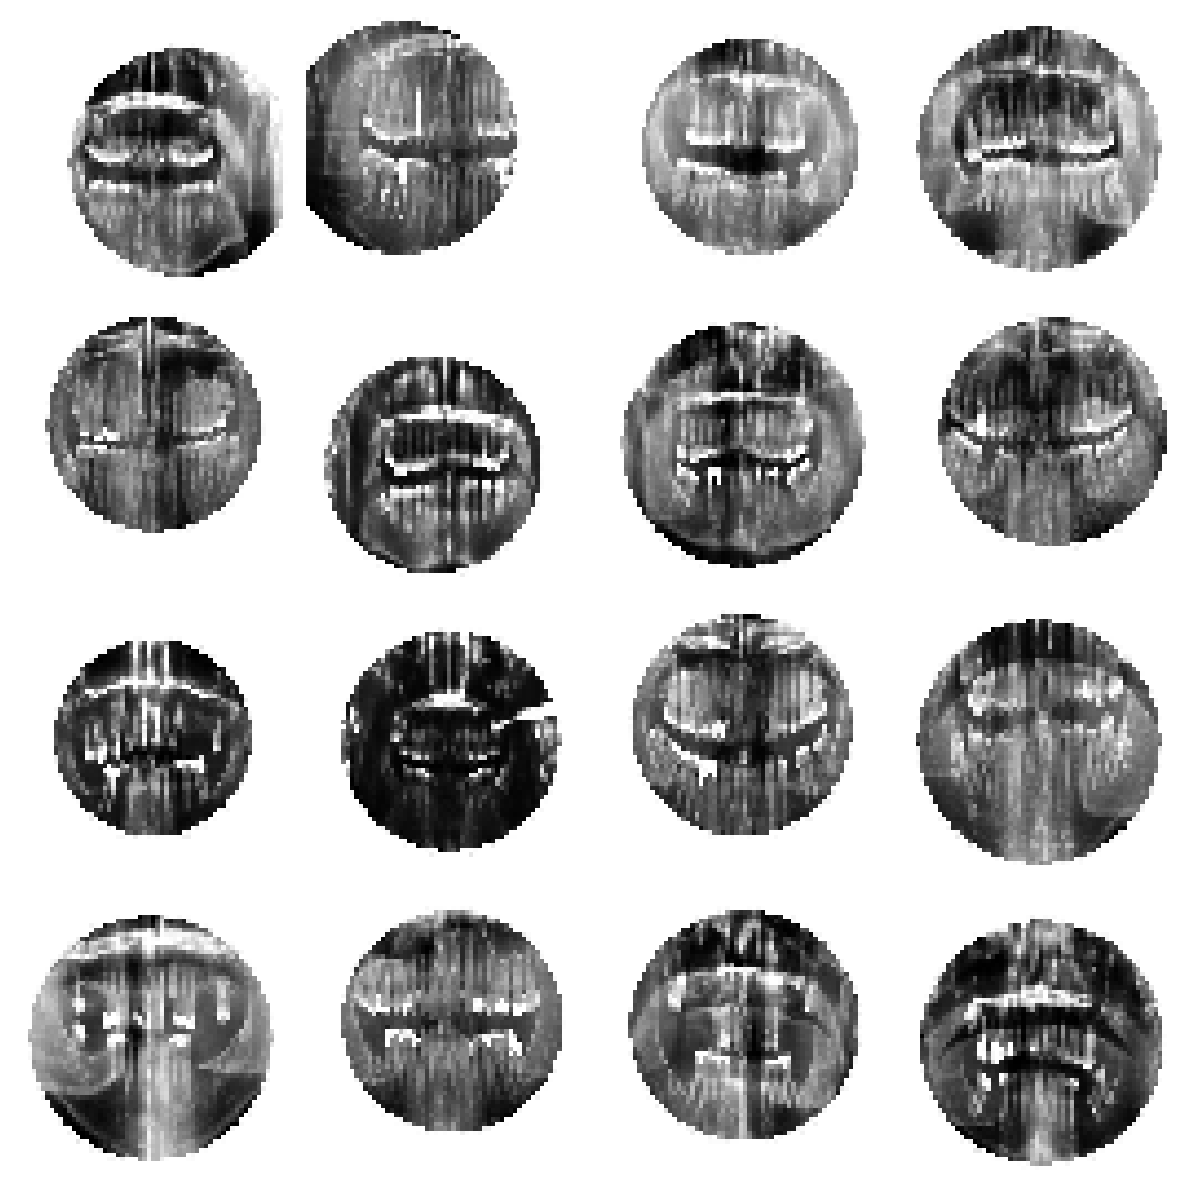

In [72]:
visualize_df(images)

In [73]:
noise_factor=0.20
noise_images=[]
for image in images:
  noisy=image+noise_factor * np.random.randn(*image.shape)
  noisy=np.clip(noisy, 0., 1.)
  noise_images.append(noisy)

In [74]:
noise_images=np.array(noise_images)

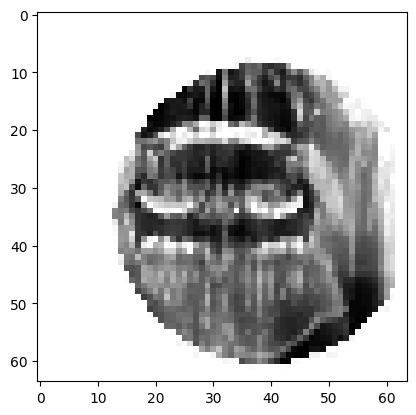

In [75]:
plt.imshow(images[0],cmap="gray")

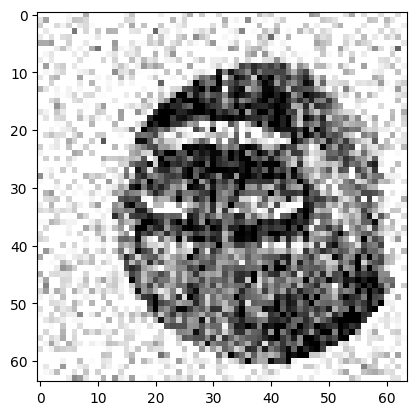

In [76]:
plt.imshow(noise_images[0],cmap="gray")

# Split Dataset

In [77]:
noise_train=noise_images[:100]
noise_test=noise_images[100:]
noise_train.shape,noise_test.shape

((100, 64, 64, 1), (21, 64, 64, 1))

In [78]:
normal_train=images[:100]
normal_test=images[100:]
normal_train.shape,normal_test.shape


((100, 64, 64, 1), (21, 64, 64, 1))

Models

In [79]:
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,MaxPooling2D,MaxPool2D,UpSampling2D,Flatten,Input
from keras.optimizers import Adam,SGD,Adadelta
from keras import backend as k


def autoencoder():
  input_img=Input(shape=(64,64,1),name=("input_img"))

  #encoder
  x=Conv2D(64,(3,3),activation='relu',padding='same',name='Conv1')(input_img)
  x=MaxPooling2D((2,2),padding='same',name='Pool1')(x)
  x=Conv2D(64,(3,3),activation='relu',padding='same',name='Conv2')(x)
  x=MaxPooling2D((2,2),padding='same',name='Pool2')(x)




  #decoder
  x=Conv2D(64,(3,3),activation='relu',padding='same',name='Conv3')(x)
  x=UpSampling2D((2,2),name='UpSample1')(x)
  x=Conv2D(64,(3,3),activation='relu',padding='same',name='Conv4')(x)
  x=UpSampling2D((2,2),name='UpSample2')(x)
  x=Conv2D(1,(3,3),activation='sigmoid',padding='same',name='Conv5')(x)

  #model
  autoencoder=Model(inputs=input_img,outputs=x)
  autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

  return autoencoder





In [80]:
model=autoencoder()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 64, 64, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 64)        640       
                                                                 
 Pool1 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 64)        36928     
                                                                 
 Pool2 (MaxPooling2D)        (None, 16, 16, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 UpSample1 (UpSampling2D)    (None, 32, 32, 64)        0   

In [83]:
model.fit(noise_train,normal_train,validation_data=(noise_test,normal_test),epochs=50,batch_size=128)

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.6891 - val_loss: 0.6474
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.6431 - val_loss: 0.6181
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.6091 - val_loss: 0.6240
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 0.6103 - val_loss: 0.6152
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 0.6018 - val_loss: 0.5941
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 0.5830 - val_loss: 0.5821
Epoch 7/50
1/1 [==============================] - 4s 4s/step - loss: 0.5731 - val_loss: 0.5740
Epoch 8/50
1/1 [==============================] - 3s 3s/step - loss: 0.5663 - val_loss: 0.5600
Epoch 9/50
1/1 [==============================] - 3s 3s/step - loss: 0.5528 - val_loss: 0.5416
Epoch 10/50
1/1 [==============================] - 3s 3s/step - loss: 0.5345 - val_loss: 0.5242
Epoch 11/50
1/1 [==============================] 

In [84]:
prdedicted=model.predict(noise_test)


1/1 [==============================] - 0s 448ms/step


In [89]:
from sklearn.metrics import mean_squared_error

actual_values_flat=normal_test.flatten()
predict_values_flat=prdedicted.flatten()

mse=mean_squared_error(actual_values_flat,predict_values_flat)
print("Mean Squared Error:",mse)

Mean Squared Error: 0.023861054


In [90]:
evaluation=model.evaluate(noise_test,normal_test)
evaluation

1/1 [==============================] - 0s 413ms/step - loss: 0.3287


0.32873451709747314

In [101]:
def plot_prediction(test,preds):
  plt.figure(figsize=(12,12))

  #Noise Test
  for i in range(16):
    plt,plt.subplot(4,8,i+1)
    plt.imshow(test[i],cmap='gray')
    plt.axis('off')
    plt.title('Noised')

  #Noise Predict
  for i in range(16):
    plt,plt.subplot(4,8,i+17)
    plt.imshow(preds[i],cmap='gray')
    plt.axis('off')
    plt.title('Predict')



  plt.show()




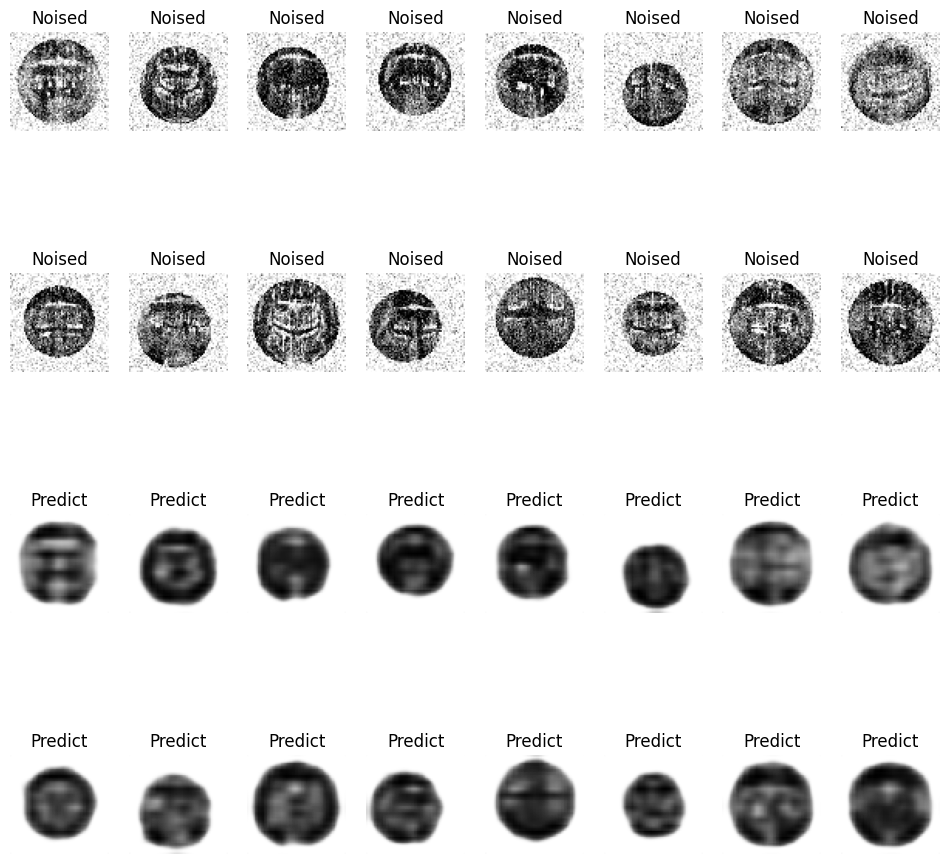

In [102]:
plot_prediction(noise_test,prdedicted)